In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from fringes import fringe_wrapper
from phase import phase_wrapper
from config import config
from phase import phase_wrapper, PE

rmse = lambda diff: np.sqrt(np.nanmean(diff ** 2))
dist = lambda points: np.sqrt(np.sum(points**2, axis=-1))

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''
def write_ply(fn, verts):
    verts = verts[:,20:-20,:]
    verts = verts.reshape(-1, 3)
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')
        
def recons3d(disparity):
    h, w = disparity.shape[0:2]
    f = 5.0*w                          # artificial focal length                      
    Q = np.float32([[5, 0, 0, -0.5*w],
                    [0,-5, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q)
    return points

methods = ["PE", "MPE", "LLS", "CFPE"]
linetypes = [":>", "--s", "-.<", "-o","-o"]

In [2]:
# config
cfg = config()
cfg.debug = False
cfg.pattern_size = [1920, 50]
cfg.Tp = [30, 33, 36]       #在这个实验中，就先设置成这个周期。

# Note that, we must update Tc and alpha for correct phase extraction
cfg.Tc = cfg.Tp # Tc is for camera recordings
cfg.alpha = [1, cfg.Tp[0]/cfg.Tp[1], cfg.Tp[0]/cfg.Tp[2]]

In [3]:
cfg.A = [128,128,128]
cfg.B = [100,100,100]
cfg.C, cfg.D, cfg.E , cfg.F= 5,4,3,2
def three_or_four_or_seven_step_manner_contract(cfg, noise_model):
    # generate the test images, ground truth of phase map and points
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)

    # phase extraction and convert to 3d points
    phase_measures = PE(cfg).phase_extract1(images=fringe_images)[0]

    disparitys = (phase_measures - phase_truth) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures = recons3d(disparitys)

    # Performance evaluation
    rmse_phase = rmse(phase_measures[:, 20:-20] - phase_truth[:, 20:-20])
    rmse_point = rmse(dist(point_measures[:, 20:-20, :] - point_truth[:, 20:-20, :]))

    return rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures


cfg.gamma=1.1
noise_model = "gamma"
cfg.steps = [3,3,3]
rmse_phase1, rmse_point1, phase_truth1, point_truth1, phase_measures1, point_measures1 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
cfg.steps = [4,4,4]
rmse_phase2, rmse_point2, phase_truth2, point_truth2, phase_measures2, point_measures2 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
cfg.steps = [7,7,7]
rmse_phase3, rmse_point3, phase_truth3, point_truth3, phase_measures3, point_measures3 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
    
print(f"RMSE(phase1):{rmse_phase1}")
print(f"RMSE(point1):{rmse_point1}")
print(f"RMSE(phase2):{rmse_phase2}")
print(f"RMSE(point2):{rmse_point2}")
print(f"RMSE(phase3):{rmse_phase3}")
print(f"RMSE(point3):{rmse_point3}")

RMSE(phase1):0.015278395085276866
RMSE(point1):0.10070379078388214
RMSE(phase2):0.0038747501374514037
RMSE(point2):0.025536665692925453
RMSE(phase3):0.0018084346546445923
RMSE(point3):0.011919916607439518


In [4]:
def case_study(cfg, noise_model):
    # generate the test images, ground truth of phase map and points
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)

    # phase extraction and convert to 3d points
    phase_measures = [phase_wrapper(cfg, m).phase_extract1(fringe_images)[0] for m in methods]
    disparitys = [(pm-phase_truth)*cfg.Tp[0]/(2*np.pi)+88 for pm in phase_measures]
    point_measures = [recons3d(disp) for disp in disparitys]

    # Performance evaluation
    rmse_phase = [rmse(p[:,20:-20]- phase_truth[:,20:-20]) for p in phase_measures]
    rmse_point = [rmse(dist(p[:,20:-20,:]- point_truth[:,20:-20,:])) for p in point_measures]
    return rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures

cfg.steps = [3,3,3]
cfg.MaxIter = 9
rmse_phase4, rmse_point4, phase_truth4, point_truth4, phase_measures4, point_measures4 = case_study(cfg,noise_model)

进入MPE方法
进入CFPE方法


self.C :  tensor([[ 0.8019,  0.3569,  0.3569,  0.8019],
        [ 1.0000,  1.4450, -0.8019, -0.8019],
        [-0.8019, -0.8019,  1.4450,  1.0000]], device='cuda:0')
完成
RMSE(phase):0.015278395085276866
RMSE(point):0.10070379078388214


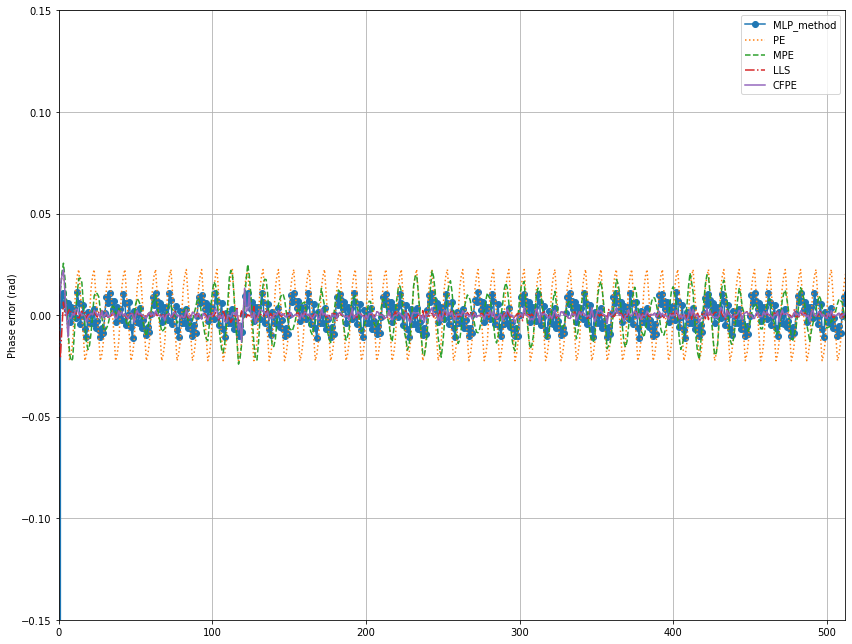

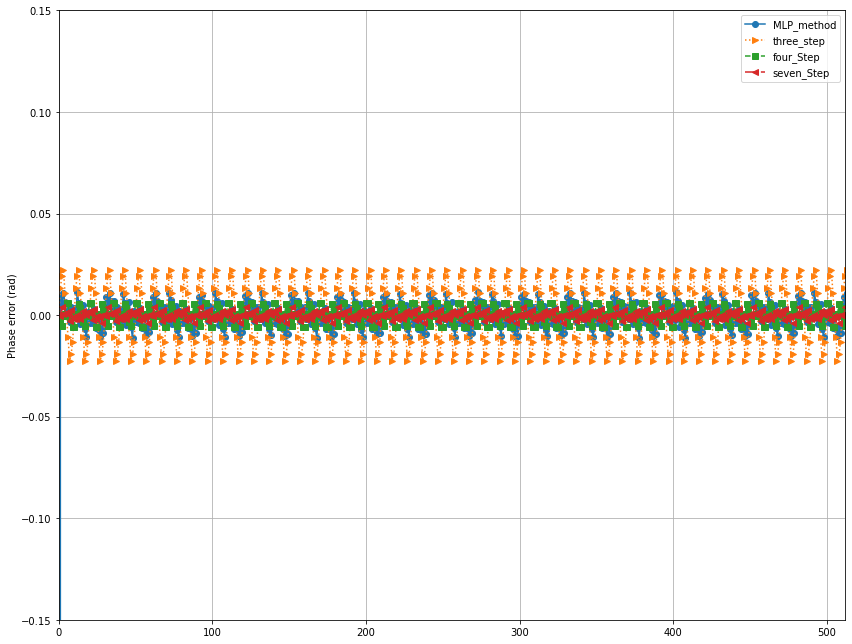

In [5]:
import torch,gc
from torch import nn
import os
import matplotlib.pyplot as plt

device = torch.device("cuda") #使用gpu进行训练
gc.collect()
torch.cuda.empty_cache()#清楚cuda缓存

class NeuralNetwork(nn.Module): #构建CNN神经网络
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.MLP = nn.Sequential(
            nn.Conv2d(9,  16, 1, stride=1),  #四个卷积层
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 5, 1, stride=1),
            nn.BatchNorm2d(5)
            # nn.ReLU(),
        )

        self.resnet =  nn.Sequential(
            nn.Conv2d(9, 5, 1, stride=1),
            nn.BatchNorm2d(5)
            # nn.ReLU()   
        )
        
        A = [[1, np.cos(0), np.sin(0)],                
             [1, np.cos(6*np.pi/7), np.sin(6*np.pi/7)],
             [1, np.cos(8*np.pi/7), np.sin(8*np.pi/7)]]
        B = [[1, np.cos(2*np.pi/7), np.sin(2*np.pi/7)],
             [1, np.cos(4*np.pi/7), np.sin(4*np.pi/7)],
             [1, np.cos(10*np.pi/7), np.sin(10*np.pi/7)],
             [1, np.cos(12*np.pi/7), np.sin(12*np.pi/7)]]
        A, B = np.array(A), np.array(B) #列表转化成数组
        self.C = torch.Tensor(np.matmul(B, np.linalg.inv(A)).transpose()).float()#B乘以A的转置矩阵就是I4到I7的前面的系数
        self.C = self.C.to(device)
        print("self.C : ",self.C)
        D = [[1, np.cos(0), np.sin(0)],
            [1, np.cos(2*np.pi/4), np.sin(2*np.pi/4)],
            [1, np.cos(4*np.pi/4), np.sin(4*np.pi/4)]]
        E = [[1, np.cos(6*np.pi/4), np.sin(6*np.pi/4)]]
        self.F = torch.Tensor(np.matmul(E, np.linalg.pinv(D)).transpose()).float()#B乘以A的转置矩阵就是I4到I7的前面的系数
        self.F = self.F.to(device)
        self.model_save_dir = "./data/model_gamma" #定义保存模型的文件夹
        self.p = os.path.join(self.model_save_dir,"best_model")
        self.last_loss = 9999999999
        self.last_epoch = 0
        
        #对数组A求逆矩阵，与B矩阵相乘
    
    def forward(self, images):
        # linear generator for the 4 images
        images = images.to(device)
        i7s = images.permute(0, 2, 3,1)            #将tensor的维度换位
        # i7s = i7s.to(device)
        i7s,_ = torch.split(i7s,(3,6),dim=-1)      #切分，得到的就是I1 I7 I8
        mids,another = torch.split(_,(3,3),dim = -1) #切分，得到4步相移的前三步

        linearPart = torch.matmul(i7s, self.C+0.0) #Y矩阵乘法 50*(1950*3)矩阵乘以3*4矩阵
        linearPart1 = torch.matmul(mids, self.F+0.0)   #矩阵乘法 50*(1950*3)矩阵乘以3*1矩阵
        linearPart = linearPart.to(device)
        linearPart1 = linearPart1.to(device)
        linearPart = linearPart.permute(0,3,1,2)   #维度换位
        linearPart1 = linearPart1.permute(0,3,1,2)   #维度换位
        linearPart2 = torch.cat([linearPart, linearPart1], 1)
        
        # The nonliear part is estimated with MLP function 
        images = images/255
        images = images.to(device)
        res1 = self.MLP(images)
        out1 = res1 + self.resnet(images)
        # out = self.resnet1(out1)
        # out = self.conv2(out1)
        # res2 = self.conv2(out1)
        # out = res2 + self.resnet2(out1)
        # print_out = nn.ReLU(out)
        # print("res.shape:{}".format(res.shape))
        # RES = res.view(-1,64*cfg.pattern_size[1]*cfg.pattern_size[0])
        # print("RES.shape:{}".format(RES.shape))
        # RES = self.classifier(RES)
        # RES1 = RES.view(len(RES),-1,cfg.pattern_size[0])
        # print("RES1.shape:{}".format(RES1.shape))
        # RES2 = RES1.view(len(RES),-1,cfg.pattern_size[1],cfg.pattern_size[0])
        # print("RES2.shape:{}".format(RES2.shape))
        
#         print("zhixingle")
        return linearPart2 + out1

def new_manner(cfg, noise_model):
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()


    img1_0, img1_3, img1_4 = fringe_images[0][0], fringe_images[0][3], fringe_images[0][4]
    img2_0, img2_1, img2_2 = fringe_images[1][0], fringe_images[1][1], fringe_images[1][2]
    img3_0, img3_1, img3_2 = fringe_images[2][0], fringe_images[2][1], fringe_images[2][2]
#     img1_1, img1_2, img1_5, img1_6, img2_3 = fringe_images[0][1], fringe_images[0][2], fringe_images[0][5], fringe_images[0][6], fringe_images[1][3]
    
#     print(img1_0)
    inputs = np.stack([img1_0, img1_3, img1_4, img2_0, img2_1, img2_2, img3_0, img3_1, img3_2]).astype(np.float32)
#     print(inputs)
    
    model = NeuralNetwork()
    model = model.to(device)
    
    checkpoint = torch.load("./data/model_gamma/best_model")
#     print(checkpoint)
    model.load_state_dict(checkpoint['model'])
    inputs = torch.Tensor(inputs)
#     print(inputs.shape)
#     print(inputs)
    inputs1 = inputs.expand([1,9,50,1920])
#     print(inputs1.shape)
#     print(inputs1)
    output_predict = model(inputs1)
#     print(output_predict)
#     print(output_predict.shape)
    chaifen1,chaifen2,chaifen3,chaifen4,chaifen5 = output_predict.chunk(5,1) #四维tensor变量降为二维tensor变量
    chaifen1 = chaifen1.squeeze().cpu().detach().numpy()                   #二维tensor变量变为numpy类型
    chaifen2 = chaifen2.squeeze().cpu().detach().numpy()
    chaifen3 = chaifen3.squeeze().cpu().detach().numpy()
    chaifen4 = chaifen4.squeeze().cpu().detach().numpy()
    chaifen5 = chaifen5.squeeze().cpu().detach().numpy()

    fringe_images[0][1] = chaifen1
    fringe_images[0][2] = chaifen2
    fringe_images[0][5] = chaifen3
    fringe_images[0][6] = chaifen4
    fringe_images[1][3] = chaifen5
#     print(img1_1)

    phase_truth1 = fringe_generator.generate_phase()
    #print(np.shape(phase_truth))
    point_truth1 = recons3d(phase_truth1 * 0 + 88)

    # phase extraction and convert to 3d points
    phase_measures1 = PE(cfg).basic_extract(images=fringe_images)[0]  #这里使用的是gamma谐波

    disparitys1 = (phase_measures1 - phase_truth1) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures1 = recons3d(disparitys1)

    # Performance evaluation
    rmse_phase1 = rmse(phase_measures1[:, 20:-20] - phase_truth1[:, 20:-20])
    rmse_point1 = rmse(dist(point_measures1[:, 20:-20, :] - point_truth1[:, 20:-20, :]))

    print("完成")
    return rmse_phase1, rmse_point1, phase_truth1, point_truth1, phase_measures1, point_measures1
    
# cfg.pattern_size = (1920, 50)
cfg.steps = [7,4,3]
# cfg.gamma=1.4
rmse_phase5, rmse_point5, phase_truth5, point_truth5, phase_measures5, point_measures5 = new_manner(cfg,noise_model)
    
print(f"RMSE(phase):{rmse_phase1}")
print(f"RMSE(point):{rmse_point1}")

# pitfall problem
plt.figure(figsize=(12,9))
plt.plot(phase_truth5[10,:] - phase_measures5[10,:], linetypes[4], label="MLP_method")  
for k, p in enumerate(phase_measures4):
    plt.plot(phase_truth4[10,:]-p[10,:], linetypes[k][:-1], label=methods[k])
plt.ylabel("Phase error (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
plt.xlim(0,512)
plt.ylim(-0.15,0.15)
plt.show()

# 精度问题
plt.figure(figsize=(12,9))
plt.plot(phase_truth5[10,:] - phase_measures5[10,:], linetypes[4], label="MLP_method")  
plt.plot(phase_truth1[10,:]-phase_measures1[10,:], linetypes[0], label="three_step")
plt.plot(phase_truth2[10,:]-phase_measures2[10,:], linetypes[1], label="four_Step")
plt.plot(phase_truth3[10,:]-phase_measures3[10,:], linetypes[2], label="seven_Step")
plt.ylabel("Phase error (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
plt.xlim(0,512)
plt.ylim(-0.15,0.15)
plt.show()
